#### Problem Description and Motivation:

The problem we are addressing is sentiment analysis of tweets towards different McDonald's stores.
The motivation behind solving this problem lies in the potential impact it can have on various domains. 

1. Customer Feedback Analysis: Sentiment analysis of tweets allows us to gain insights into customers' experiences and opinions about different McDonald's stores. By understanding the sentiment expressed in tweets, McDonald's can identify areas of improvement or strengths in specific store locations. This information can be valuable for enhancing customer satisfaction and loyalty.

2. Brand Reputation Management: Monitoring the sentiment towards McDonald's stores on social media platforms can help the company manage its brand reputation effectively. By analyzing the sentiment of tweets, McDonald's can promptly address any negative sentiment or concerns raised by customers, mitigating potential reputational damage and fostering a positive brand image.

3. Market Research: Sentiment analysis of tweets provides valuable market insights. By understanding customers' sentiment towards different McDonald's stores, the company can identify trends, preferences, and areas of opportunity. This information can guide decision-making processes, such as expansion plans, marketing strategies, or menu modifications, to better align with customer expectations and market demands.

4. Social Media Monitoring: Sentiment analysis of tweets allows McDonald's to monitor the social media landscape and stay connected with its customer base. By analyzing sentiments expressed in real-time, McDonald's can identify emerging trends, address customer concerns promptly, and engage with customers in a more personalized manner, fostering brand loyalty and positive customer experiences.

5. Public Opinion Analysis: Sentiment analysis of tweets related to McDonald's stores can provide insights into the public's perception of the brand. This information can be used to gauge public sentiment towards McDonald's as a whole or specific store locations, helping the company make informed decisions and adapt its strategies to align with public sentiment.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [89]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
nltk.download('wordnet')
from nltk import stem
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91909\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### The Datasets being used to test: 
1. General Tweets classified as positive or negative or neutral sentiments
2. McDonald's Store Review

#### Data to train/fine-tune some of our models (tweets):

In [7]:
# Get data from csv from a folder called data/tweets in a directory above the current directory
train = pd.read_csv('../data/tweets/train.csv').drop(['textID', 'selected_text'], axis=1)
# pretty print the first 3 rows and the description of the data
print(train.head(3))
print('-'*50)
print(train.describe())

                                             text sentiment
0             I`d have responded, if I were going   neutral
1   Sooo SAD I will miss you here in San Diego!!!  negative
2                       my boss is bullying me...  negative
--------------------------------------------------
                                        text sentiment
count                                  27480     27481
unique                                 27480         3
top      I`d have responded, if I were going   neutral
freq                                       1     11118


#### Data to validate some of our models (tweets):

In [2]:
test = pd.read_csv('../data/tweets/test.csv').drop(['textID'], axis=1)
print(test.head(3))
print('-'*50)
print(test.describe())

                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  positive
2  Recession hit Veronique Branquinho, she has to...  negative
--------------------------------------------------
                                                     text sentiment
count                                                3534      3534
unique                                               3534         3
top     Last session of the day  http://twitpic.com/67ezh   neutral
freq                                                    1      1430


#### Data we'd like to $ sentiment$ $analyse $ for our business usecase, and thus simultaneously demonstrate the reusabilty of models trained on a text corpus

In [22]:

McDf = pd.read_csv('../data/McDonald_s_Reviews.csv', encoding='latin-1', index_col='reviewer_id')
McDf = McDf.loc[McDf['review'].str.contains(r'[^\x00-\x7F]+') == False]
McDf.head(3)

,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
reviewer_id,,,,,,,,,
1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


* reviewer_id: Unique identifier for each reviewer (anonymized)
* store_name: Name of the McDonald's store
* category: Category or type of the store
* store_address: Address of the store
* latitude: Latitude coordinate of the store's location
* longitude: Longitude coordinate of the store's location
* rating_count: Number of ratings/reviews for the store
* review_time: Timestamp of the review
* review: Textual content of the review
* rating: Rating provided by the reviewer

## EDA, Data Cleaning, Feature Engineering, and Preprocessing

#### Notice there's hyperlinks in the tweets. This should prompt to cleanse our data from hyperlinks and other special characters.
#### But before, let's visualise the distribution of the tweets' sentiments

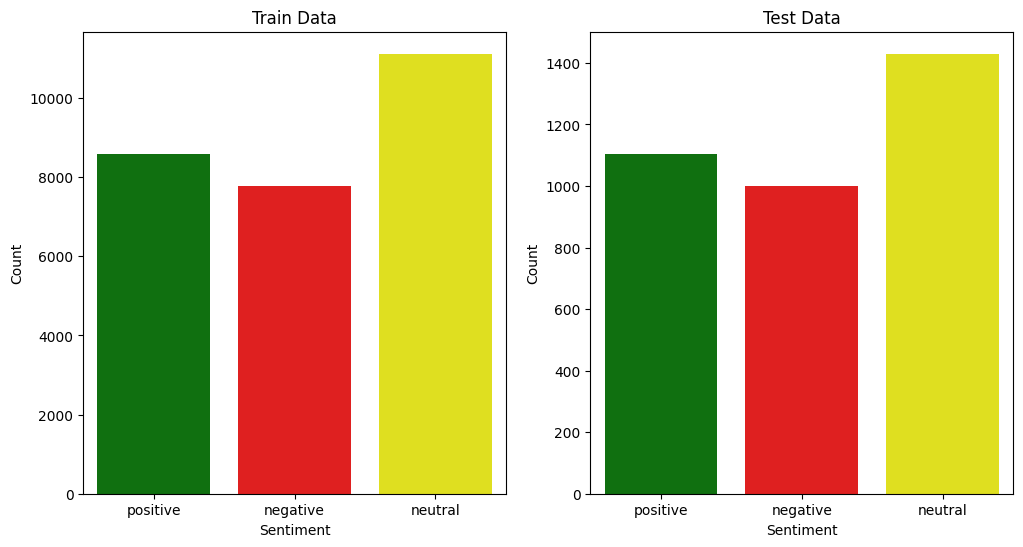

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of sentiment categories
sentiment_order = ['positive', 'negative', 'neutral']

# Define the colors for each sentiment category
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'yellow'}

# Count plot of the sentiment column for both train and test data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='sentiment', data=train, order=sentiment_order, palette=colors.values(), ax=ax[0])

ax[0].set_title('Train Data')
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Count')

sns.countplot(x='sentiment', data=test, order=sentiment_order, palette=colors.values(), ax=ax[1])

ax[1].set_title('Test Data')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('Count')

plt.show()


#### $Insight$ :The data points in both sets are drawn from the same underlying distribution and are independent of each other

In [76]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


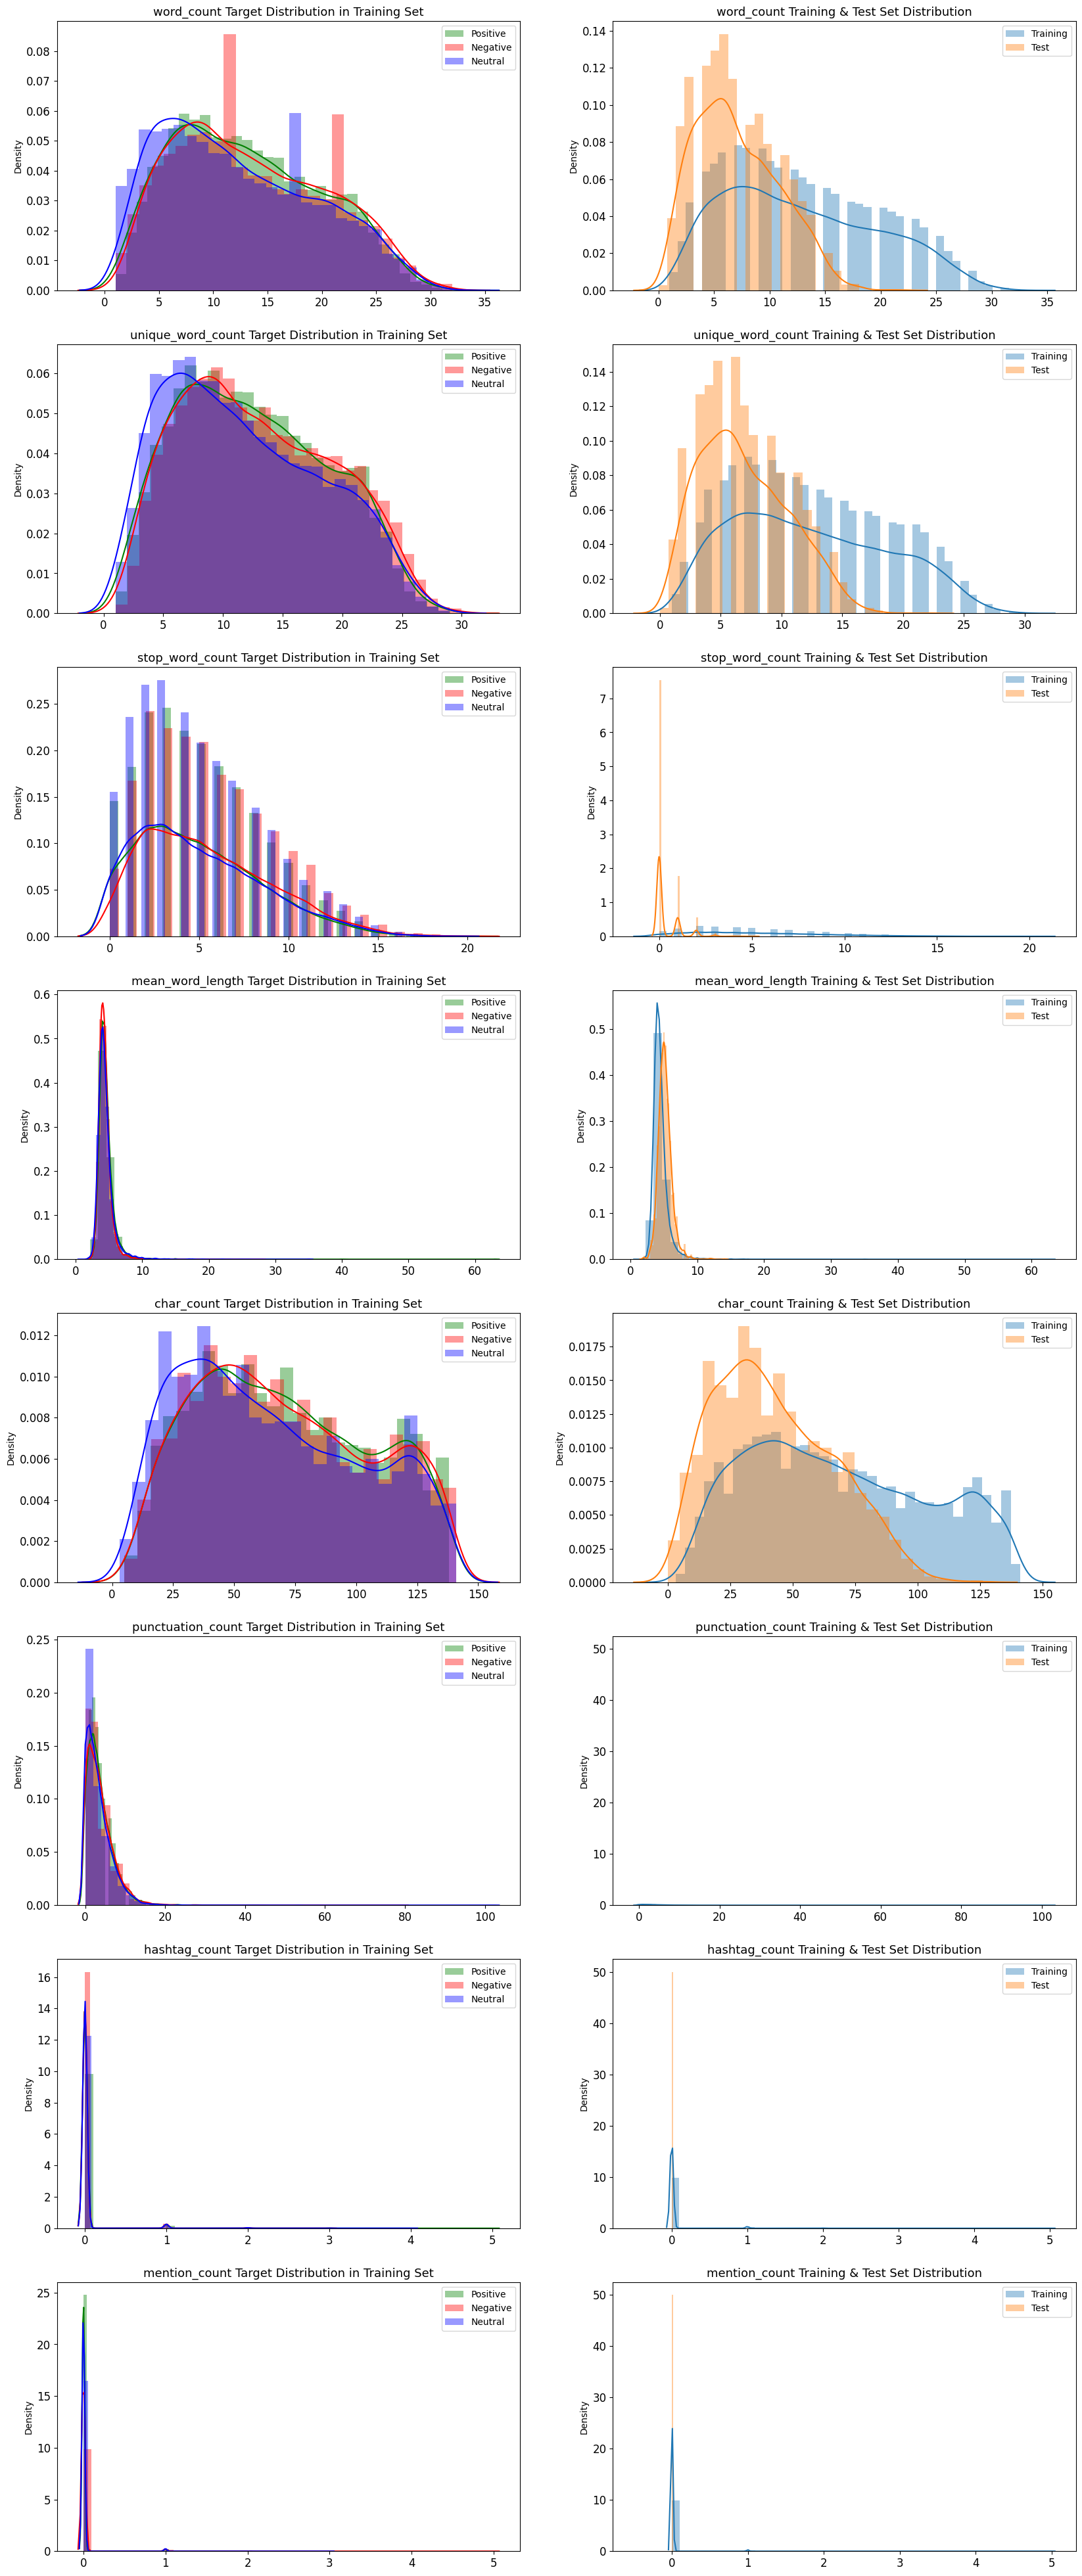

In [77]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
        'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

TWEETS = train['sentiment'] == 1

fig, axes = plt.subplots(ncols = 2, nrows = len(METAFEATURES), figsize = (20, 50), dpi = 100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[train['sentiment'] == 'positive'][feature], label = 'Positive', ax = axes[i][0], color = 'green')
    sns.distplot(train.loc[train['sentiment'] == 'negative'][feature], label = 'Negative', ax = axes[i][0], color = 'red')
    sns.distplot(train.loc[train['sentiment'] == 'neutral'][feature], label = 'Neutral', ax = axes[i][0], color = 'blue')

    sns.distplot(train[feature], label = 'Training', ax = axes[i][1])
    sns.distplot(test[feature], label = 'Test', ax = axes[i][1])
  
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis = 'x', labelsize = 12)
        axes[i][j].tick_params(axis = 'y', labelsize = 12)
        axes[i][j].legend()
  
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize = 13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize = 13)

plt.show()

#### Let's now clean the data from hyperlinks, mentions, stopwords and other special characters.
#### We'll also lemmatize the tweets to reduce the number of unique words in the corpus

In [86]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('im ', '', text)
    return text

In [90]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train.head()


In [81]:
from collections import Counter

train['temp_list'] = train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='inferno')

,Common_words,count
0,i,13169
1,to,10012
2,the,8980
3,a,6710
4,my,5510
5,and,5067
6,you,4807
7,it,4059
8,is,3973
9,in,3783


In [82]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91909\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### After some clean up, we'll go ahead and explore the data

In [83]:
# Find the top 20 words on each sentiment

Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(10))
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

#MosT common neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(10))
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

# Display all 3, temp_positive, temp_negative, temp_neutral gradients side by side
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3, subplot_titles=("Positive", "Negative", "Neutral"))

fig.add_trace(
    go.Bar(x=temp_positive['Common_words'], y=temp_positive['count'], marker=dict(color=temp_positive['count'], coloraxis="coloraxis")),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=temp_negative['Common_words'], y=temp_negative['count'], marker=dict(color=temp_negative['count'], coloraxis="coloraxis")),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=temp_neutral['Common_words'], y=temp_neutral['count'], marker=dict(color=temp_neutral['count'], coloraxis="coloraxis")),
    row=1, col=3
)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,title_text="Top 10 Common Words in Tweets")
fig.show()

### Let's create word clouds to visualise the most frequent words in each sentiment

In [84]:
from wordcloud import ImageColorGenerator, WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = None)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

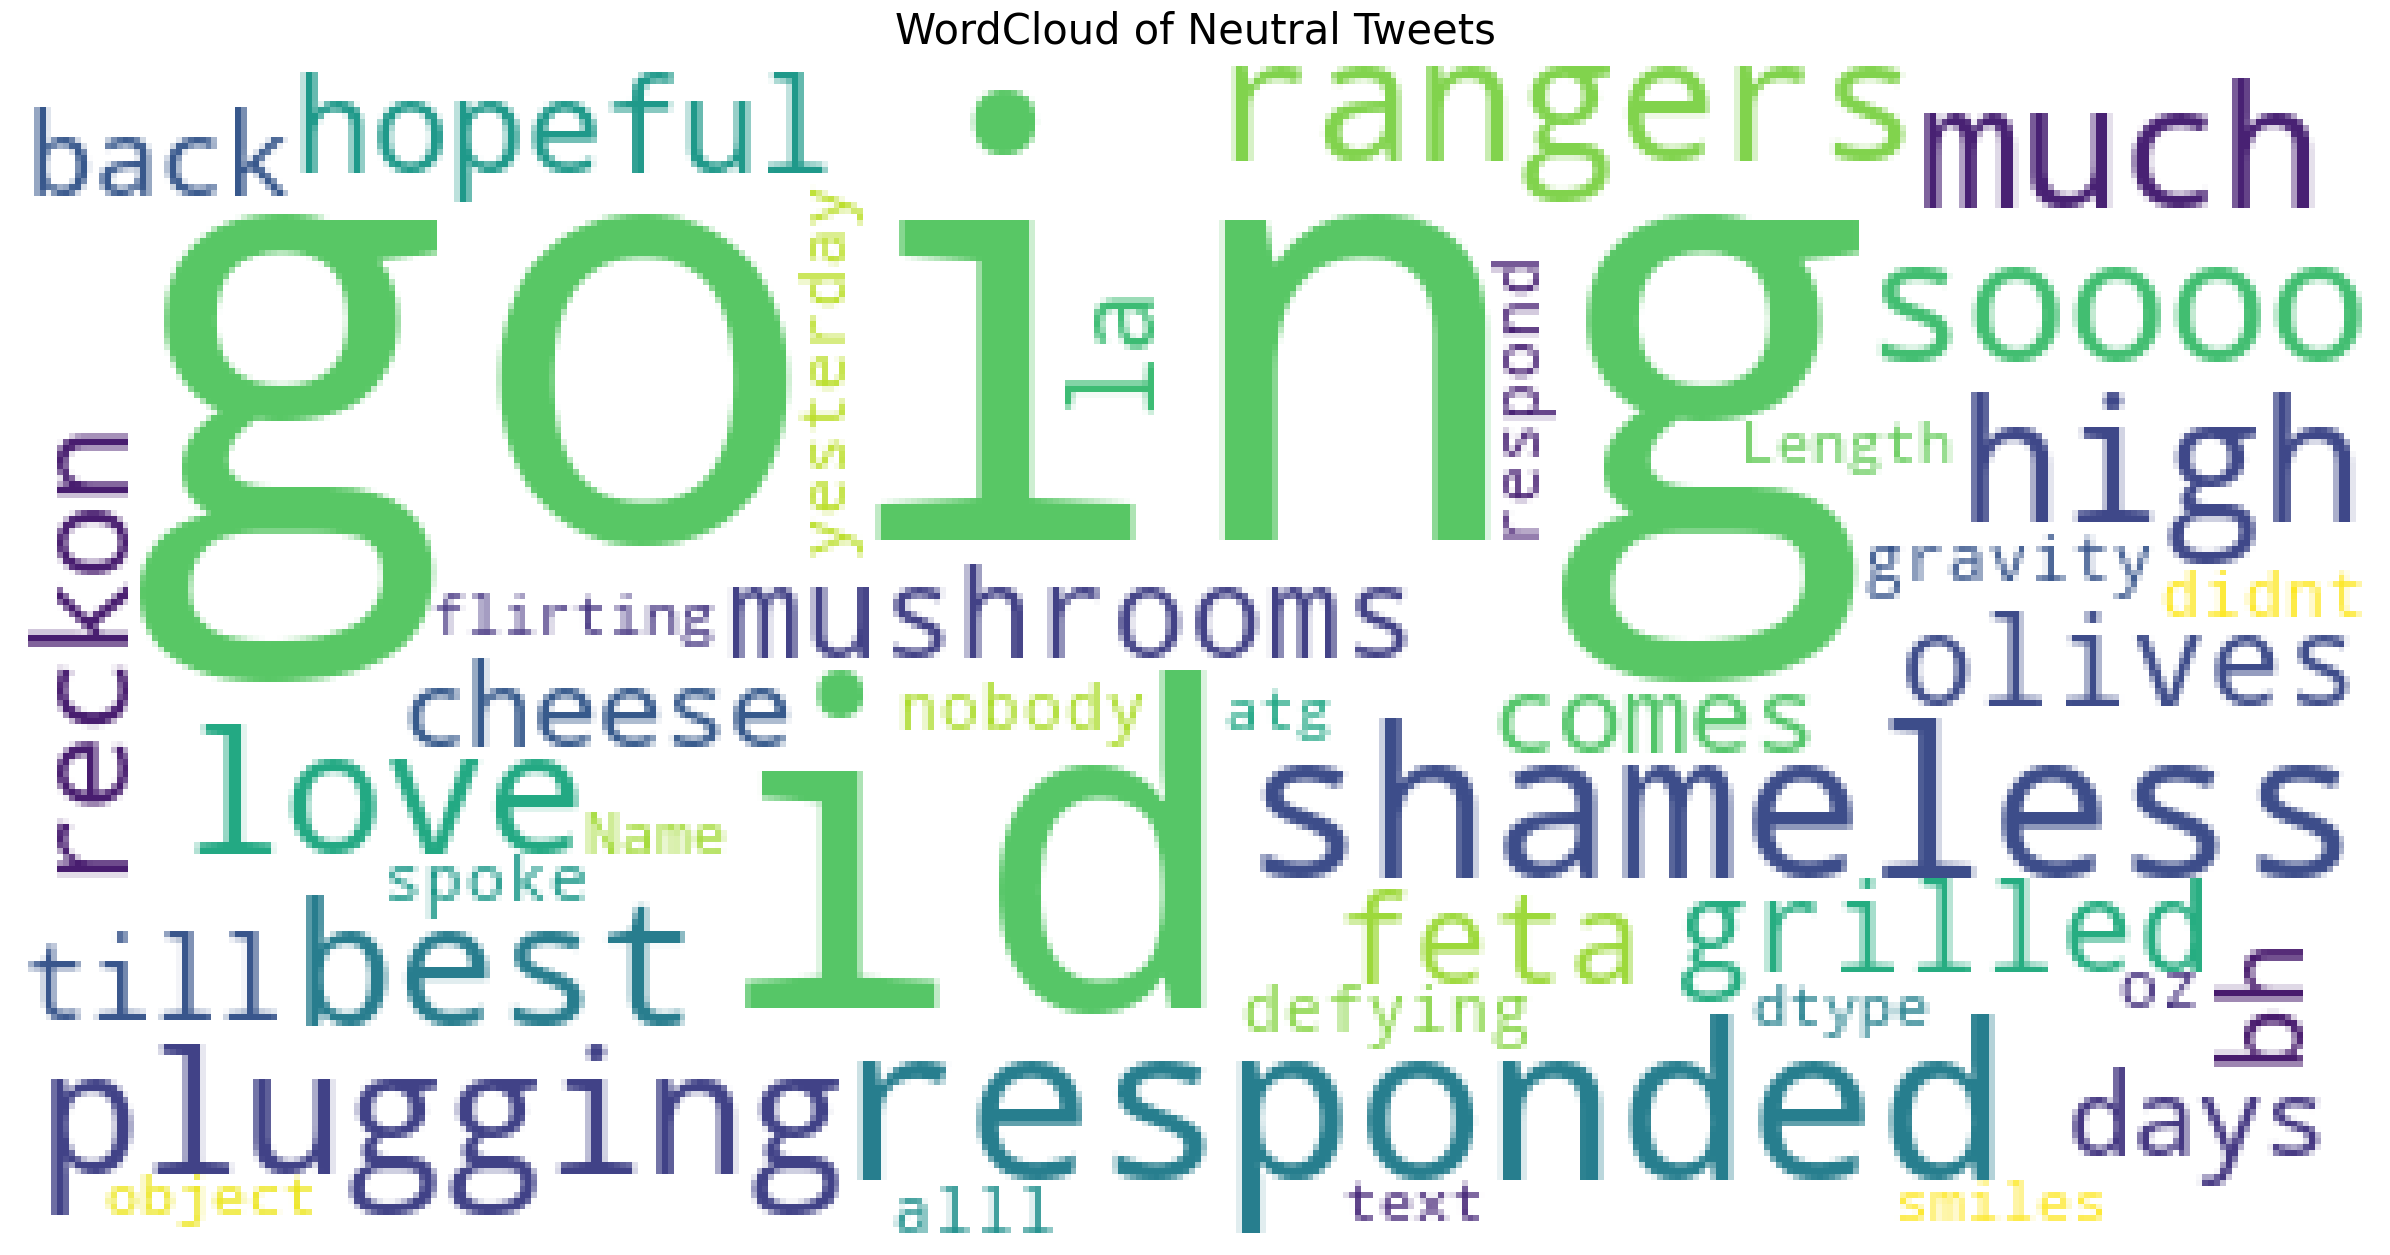

In [85]:
pos_mask = np.array('twit.png')
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

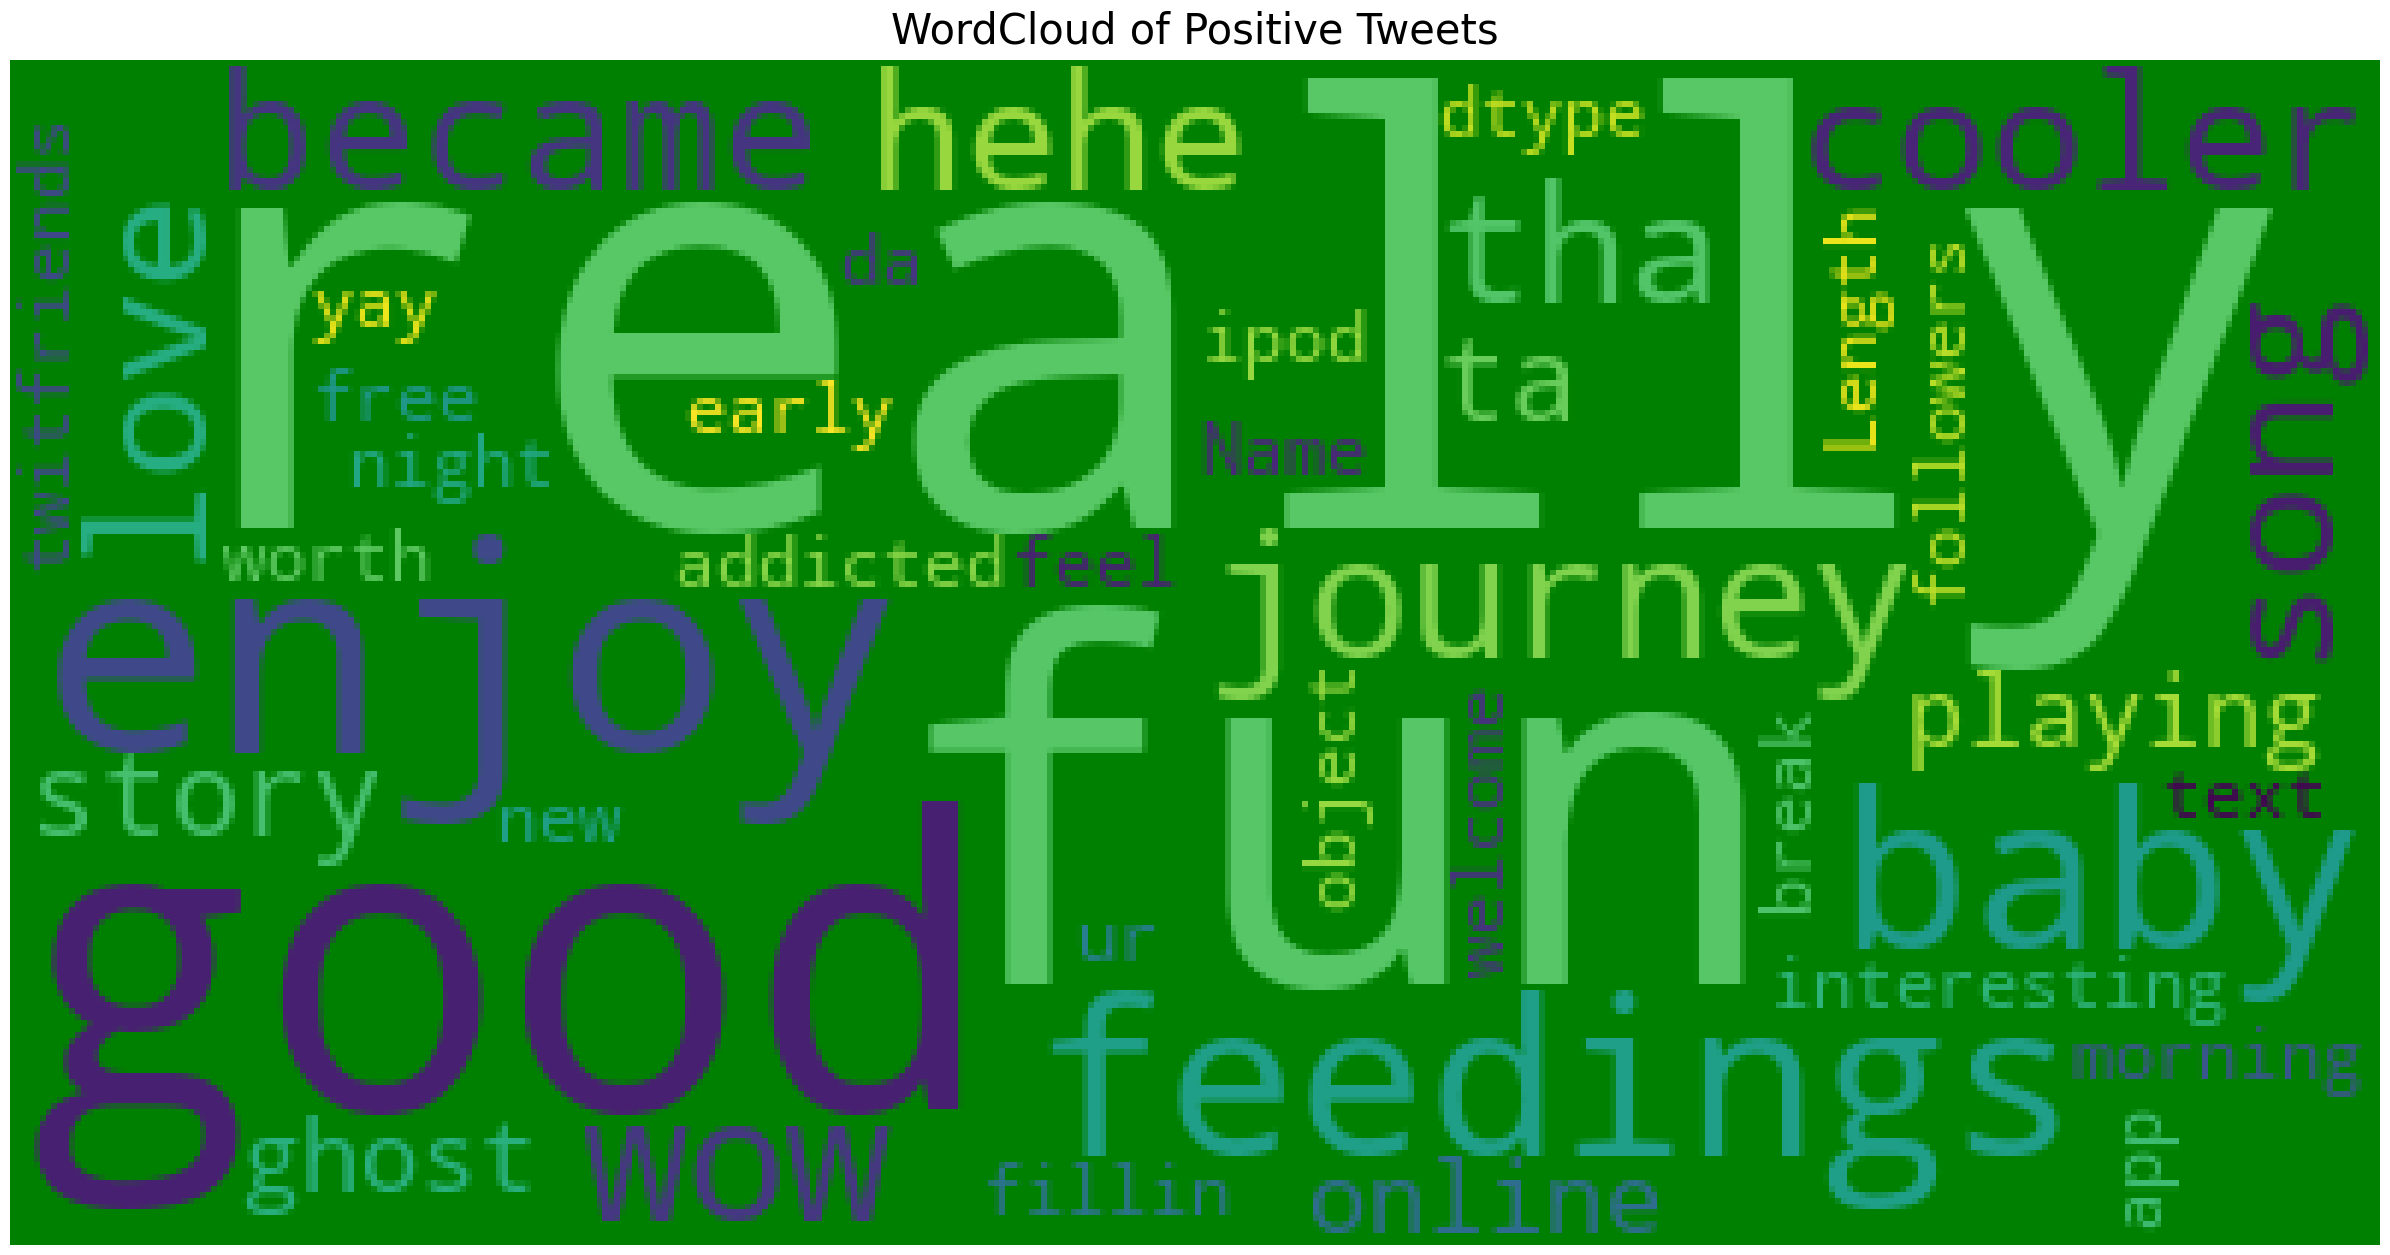

In [87]:
pos_mask = np.array('twit.png')
plot_wordcloud(Positive_sent.text,mask=pos_mask,color='green',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

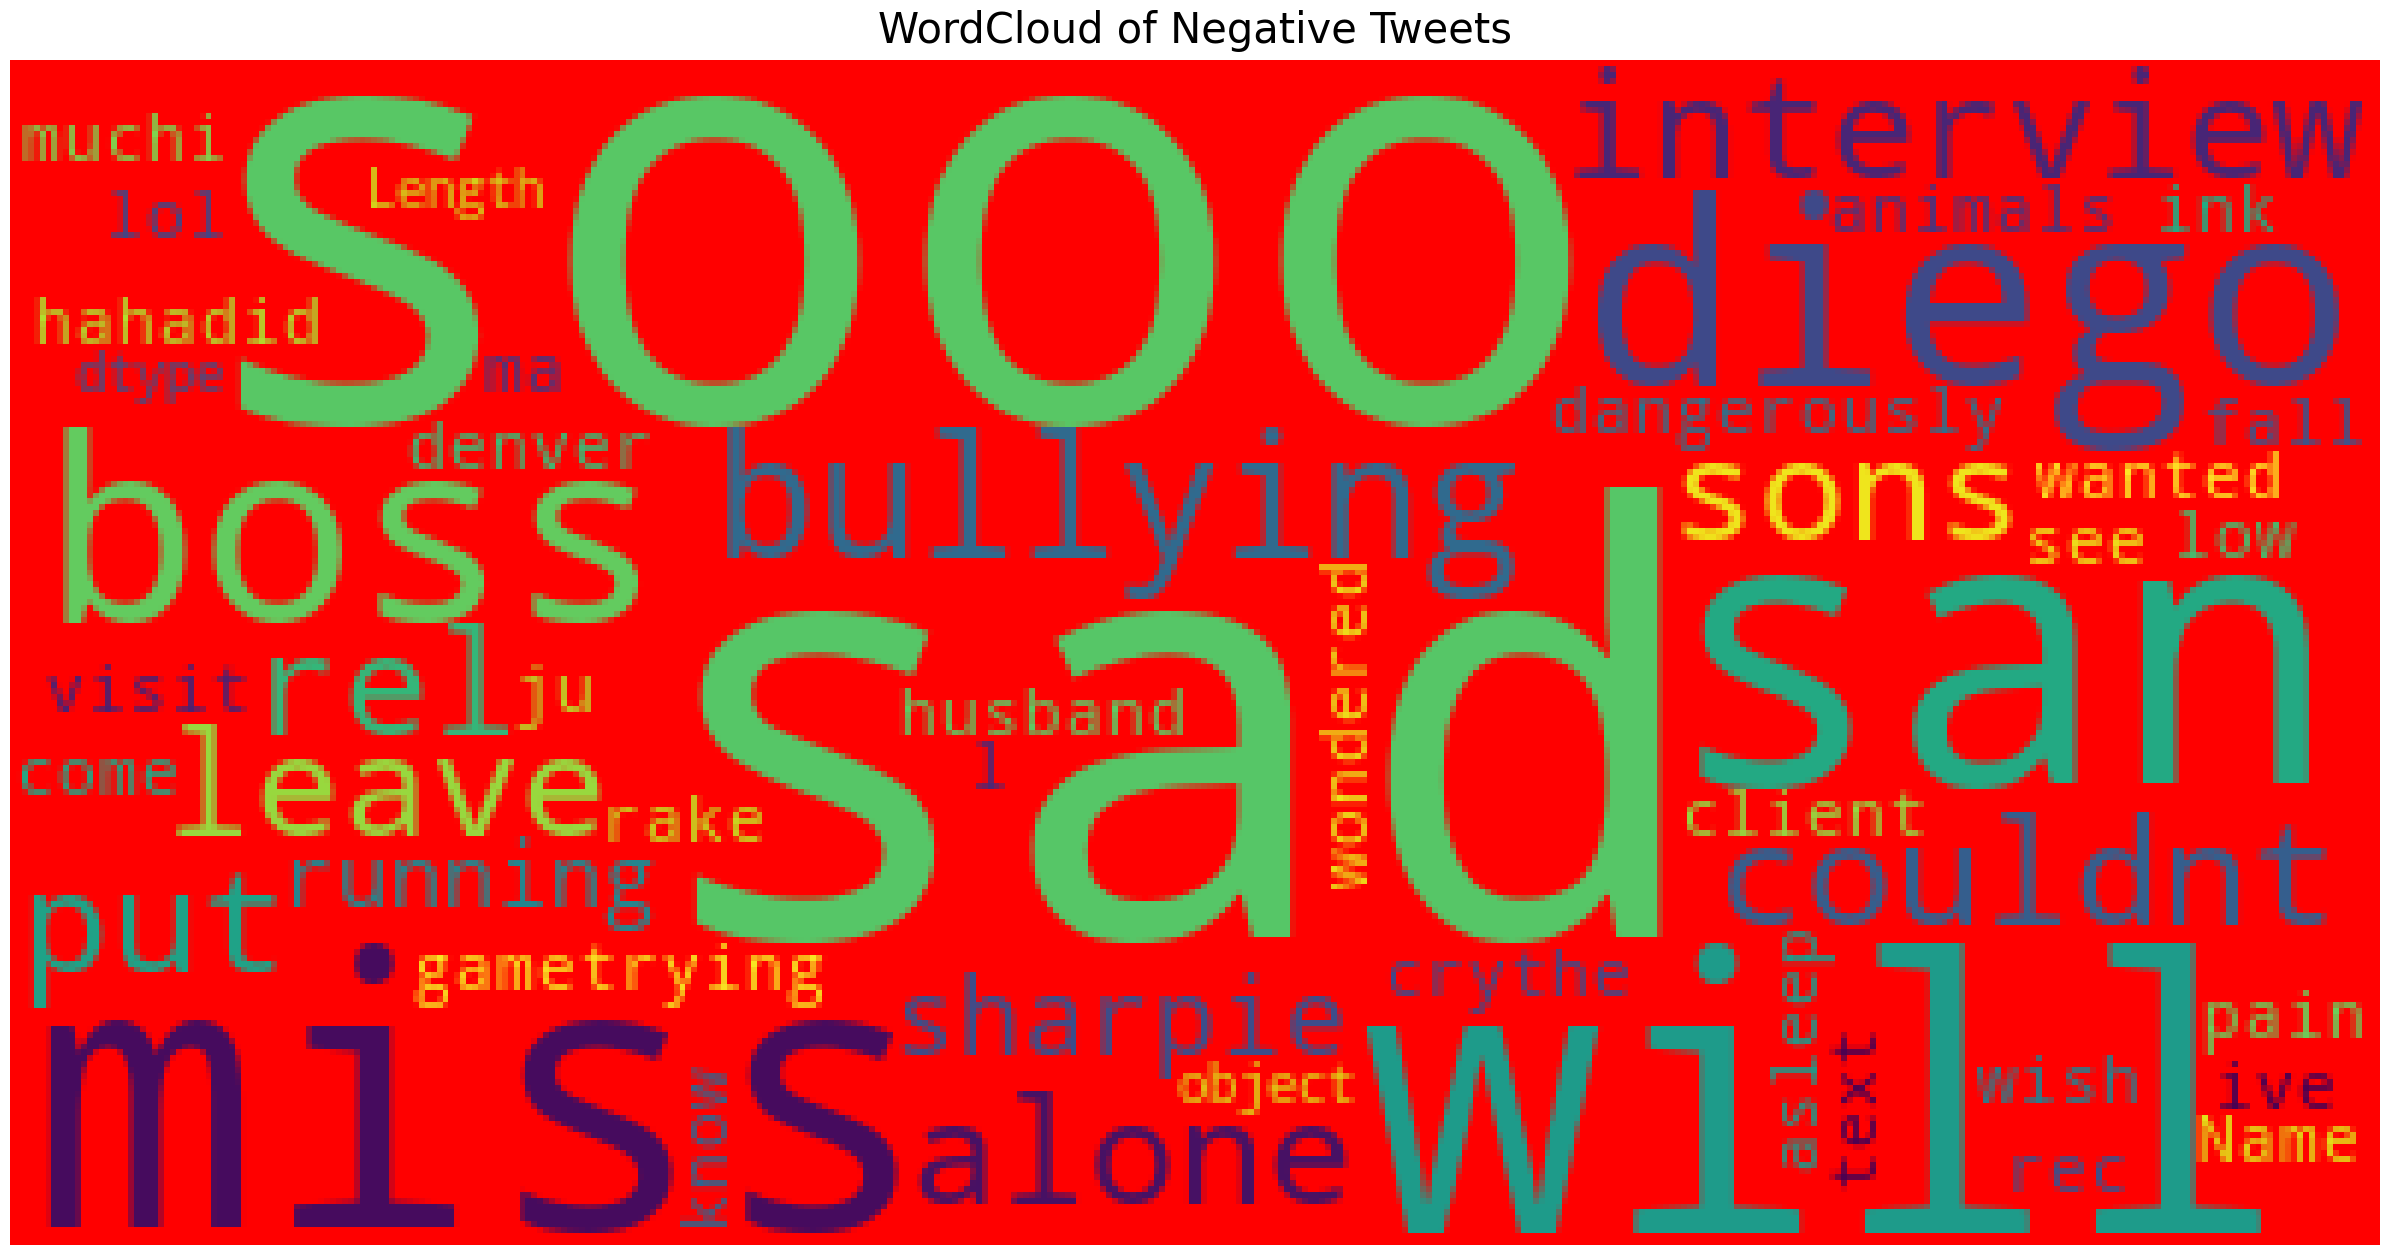

In [88]:
pos_mask = np.array('twit.png')
plot_wordcloud(Negative_sent.text,mask=pos_mask,color='red',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

Train Data size: 20610
Test Data size 6871


In [94]:
train.head()

,text,sentiment,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,temp_list
0,id have responded if i were going,neutral,7,7,4,4.142857,36,2,0,0,"[id, responded, going]"
1,sooo sad i will miss you here in san diego,negative,10,10,4,3.600000,46,3,0,0,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me,negative,5,5,2,4.200000,25,3,0,0,"[boss, bullying]"
3,what interview leave me alone,negative,5,5,2,5.200000,31,1,0,0,"[interview, leave, alone]"
4,sons of why couldnt they put them on the rel...,negative,14,14,7,4.357143,75,6,0,0,"[sons, couldnt, put, releases, already, bought]"


## Models: traing and fine tuning

### Keras Tokenizer
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf
So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Train.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

In [6]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

In [7]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

c:\Users\91909\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91909\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def compute_metrics(eval_pred):
    load_f1 = f1_score
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    load_accuracy = accuracy_score
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)['accuracy']
    f1 = load_f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    
    return {'accuracy':accuracy, 'f1':f1}

In [ ]:
#  plot distribution of scores for each rating
import seaborn as sns
sns.countplot(x='sentiment', data=train)
